In [1]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data =  pd.read_csv("salesweekly.csv")
data.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,1/26/2014,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2/2/2014,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


In [3]:
import datetime as dt
data1 = data
data1['datum'] = pd.to_datetime(data1['datum'], format= '%m/%d/%Y')
data1['year'] = data1['datum'].dt.year
data1['month'] = data1['datum'].dt.month
data1['day'] = data1['datum'].dt.day


In [4]:
data = data1
data

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,year,month,day
0,2014-01-05,14.00,11.670,21.30,185.950,41.0,0.0,32.000000,7.00,2014,1,5
1,2014-01-12,29.33,12.680,37.90,190.700,88.0,5.0,21.000000,7.20,2014,1,12
2,2014-01-19,30.67,26.340,45.90,218.400,80.0,8.0,29.000000,12.00,2014,1,19
3,2014-01-26,34.00,32.370,31.50,179.600,80.0,8.0,23.000000,10.00,2014,1,26
4,2014-02-02,31.02,23.350,20.70,159.880,84.0,12.0,29.000000,12.00,2014,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
297,2019-09-15,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50,2019,9,15
298,2019-09-22,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00,2019,9,22
299,2019-09-29,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10,2019,9,29
300,2019-10-06,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13,2019,10,6


# Seasonality analysis

The seasonality patterns can be explored in detail by using boxplots. Seasonality is clearly confirmed for the categories of R03, R06 and N02BE. Some additional conclusions: R03 and N05C has more outliers that the others, indicating that their sales is more difficult to predict.

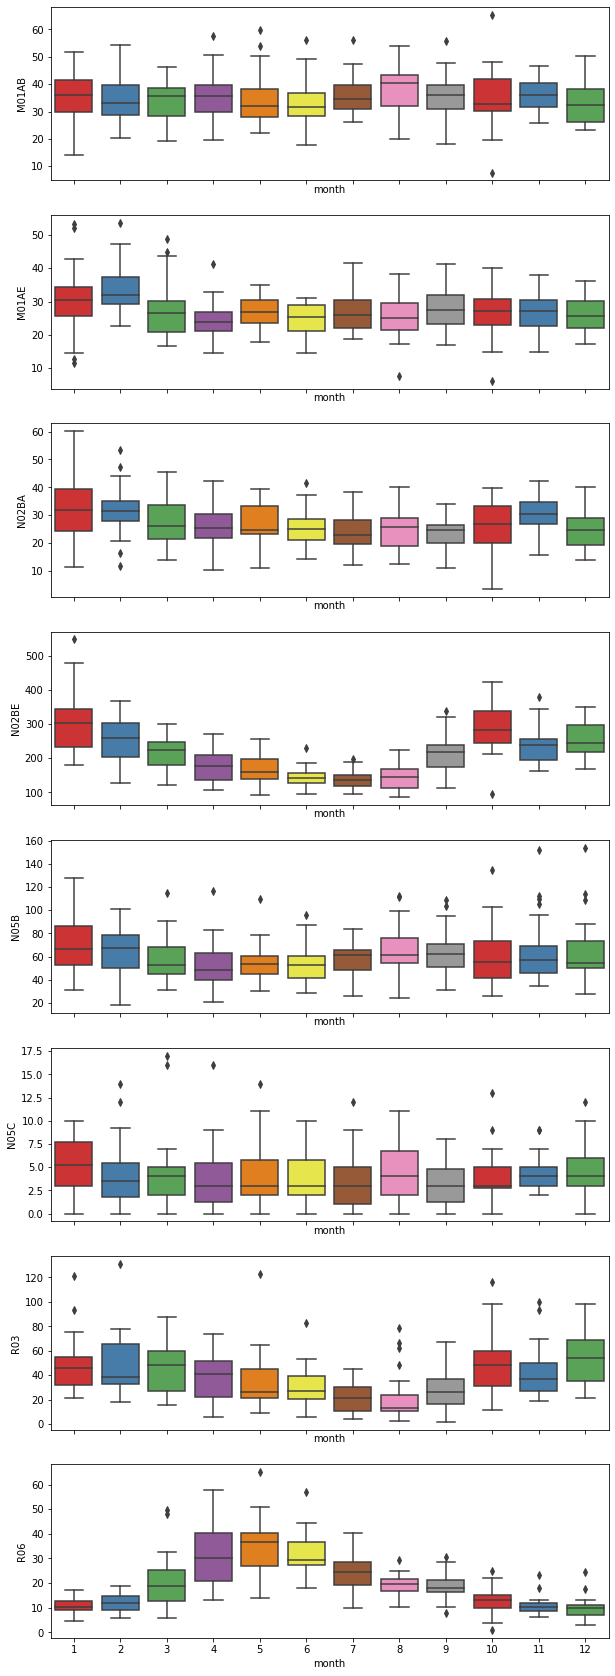

In [ ]:
import seaborn as sns
dfatc_daily = data
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='month',palette='Set1' ,y=name, ax=ax)
    

Another visualization that can be useful for discovering seasonality patterns is related to rolling window means. Rolling window operations are another important transformation for time series data.

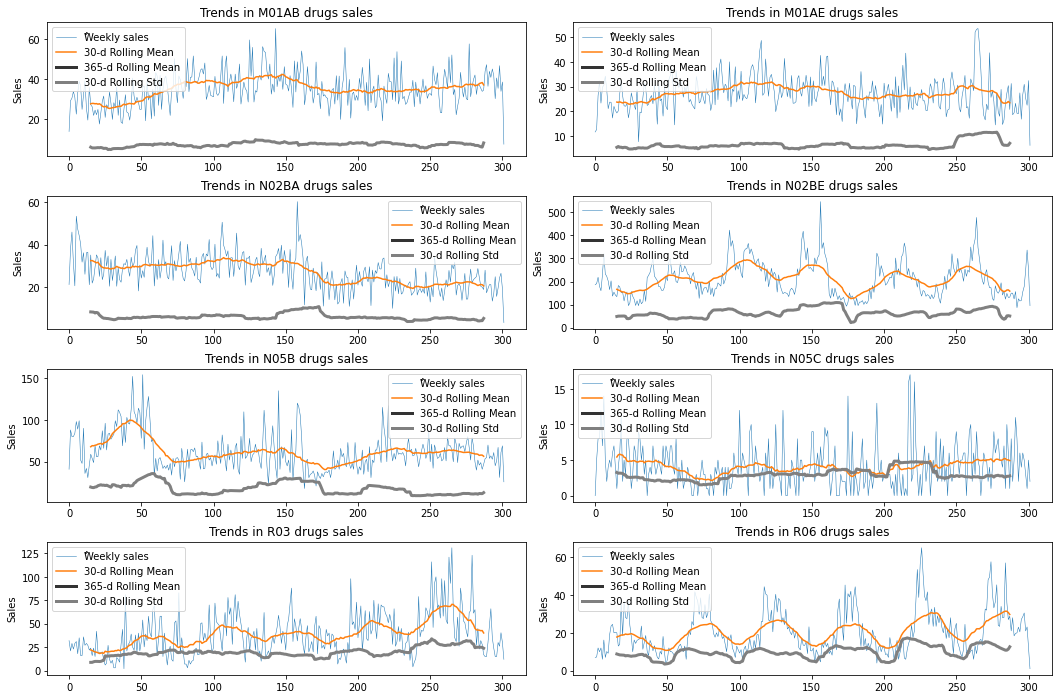

In [9]:
dfatc_daily=data
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='ٌWeekly sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()

Function seasonal_decompose can be used for analysis of the portions of each component of time series. This is especially useful when determining uptake of residuals in data, based on the decomposed data. 

In [ ]:
df = data
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(df[x], freq=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:5.26715996284115, OBSMEAN:35.59490833332001, PERC:14.797509558159527%
M01AE RESMEAN:4.319542609675869, OBSMEAN:28.00801458336, PERC:15.422523423856601%
N02BA RESMEAN:3.9228389592521657, OBSMEAN:27.083016, PERC:14.484498178682042%
N02BE RESMEAN:29.534357236963668, OBSMEAN:217.6597028336, PERC:13.569051529737028%
N05B RESMEAN:12.94840305932125, OBSMEAN:61.96614999972, PERC:20.895929566997072%
N05C RESMEAN:2.0384606385595405, OBSMEAN:3.871833333332, PERC:52.648460382081936%
R03 RESMEAN:11.722244335544508, OBSMEAN:40.06845833336, PERC:29.25554119906046%
R06 RESMEAN:4.278758416393868, OBSMEAN:19.744589999960002, PERC:21.67053565762842%


# Stationarity analysis

Stationarity of time-series is the property of exhibiting constant statistical properties over time (for example, mean, variance, autocorrelation). It can be visually determined by plotting rolling statistics (rolling means and variances). In stationary time series, the mean of the series, variance of the series and covariance of the i th term and the (i + m) th term should not be a function of time.

In [ ]:
df= data
from statsmodels.tsa.stattools import adfuller

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for M01AB
-----------------------------
Test statistic = -3.700
P-value = 0.022
Critical values :
	1%: -3.9897903649837616 - The data is not stationary with 99% confidence
	5%: -3.425478311521626 - The data is  stationary with 95% confidence
	10%: -3.1358607194990724 - The data is  stationary with 90% confidence
ADF test for M01AE
-----------------------------
Test statistic = -8.717
P-value = 0.000
Critical values :
	1%: -3.98926783537037 - The data is  stationary with 99% confidence
	5%: -3.425226747185185 - The data is  stationary with 95% confidence
	10%: -3.1357131066666666 - The data is  stationary with 90% confidence
ADF test for N02BA
-----------------------------
Test statistic = -2.670
P-value = 0.249
Critical values :
	1%: -3.990441532957606 - The data is not stationary with 99% confidence
	5%: -3.425791763669738 - The data is not stationary with 95% confidence
	10%: -3.1360446341572343 - The data is not stationary with 90% confidence
ADF test for N02BE
------------

Augmented Dickey-Fuller (ADF) test have shown that all data, but N02BA (P-value=0.249) in the series were stationary, with maximum confidence.

In [ ]:
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings("ignore")
df=data
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    print(" > Is "+x+" data stationary ?")
    dftest = kpss(np.log(df[x]), 'ct')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[3].items():
        print("\t{}: {}".format(k, v))

 > Is M01AB data stationary ?
Test statistic = 0.285
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is M01AE data stationary ?
Test statistic = 0.242
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BA data stationary ?
Test statistic = 0.147
P-value = 0.049
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BE data stationary ?
Test statistic = 0.076
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05B data stationary ?
Test statistic = 0.143
P-value = 0.056
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05C data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R03 data stationary ?
Test statistic = 0.046
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R06 data stationary ?
Test statistic = 0.027
P-value = 0.100
Cri

# Regularity analysis

For calculating regularity and predictability of time series, Approximate Entropy test was used.

In [ ]:
df = data    
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

M01AB: 1.141130089570642
M01AE: 1.166363924596575
N02BA: 1.1370638730125302
N02BE: 1.058024809082593
N05B: 1.074437415034502
N05C: 1.0361887401424648
R03: 1.1847216239035152
R06: 1.031759595747876


# Autocorrelation analysis

Autocorrelation analysis illustrates the potential for time series data prediction. Autocorrelation plots graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. Pearson coefficient is used to measure autocorrelation. Thus, the following analysis is relevant only for data with normal Gaussian distribution.

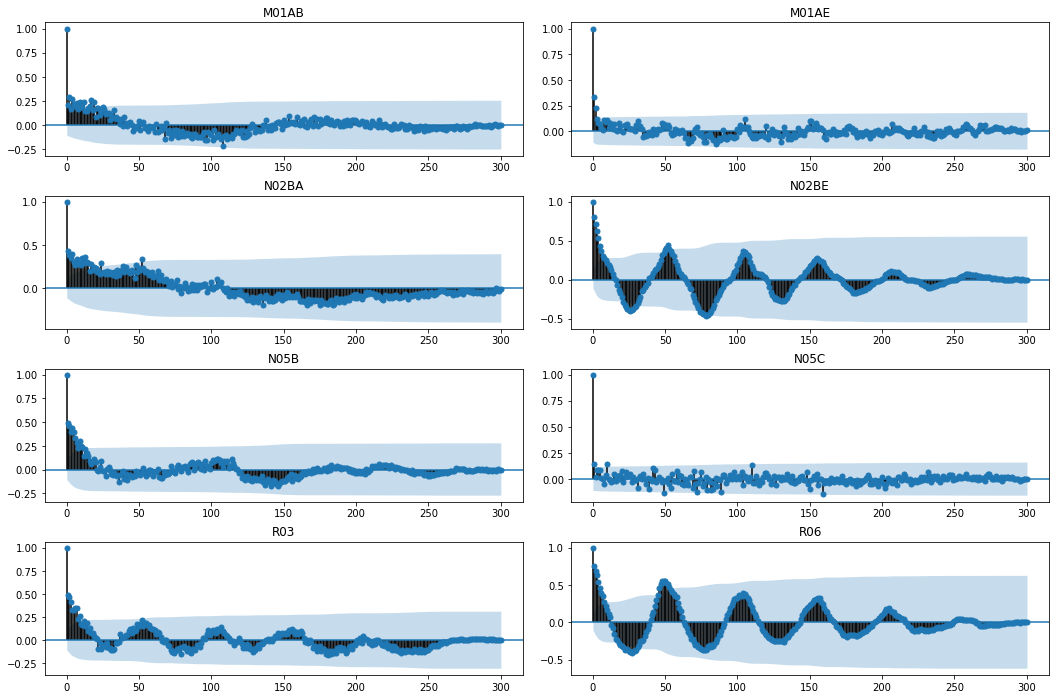

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
df = data
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=300, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

In general, the "partial" correlation between two variables is the amount of correlation between them which is not explained by their mutual correlations with a specified set of other variables.

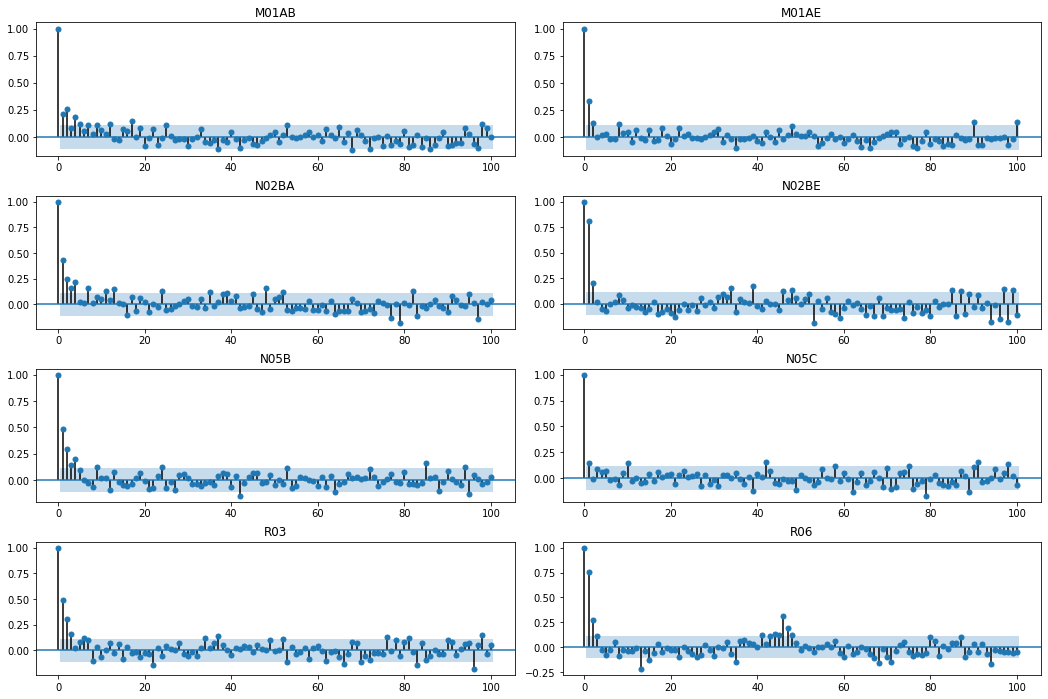

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
df = data
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

# Data distribution analysis

Chart with daily sales for different categories of interest is shown below.

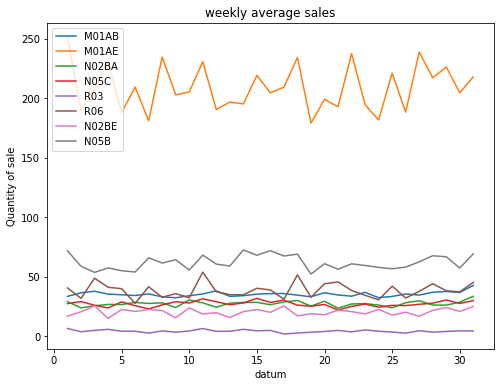

In [6]:
dfatch= data
dfatch['datum']= pd.to_datetime(dfatch['datum']) 

grp1=dfatch.groupby(dfatch.datum.dt.day)['M01AB'].mean()
grp2=dfatch.groupby(dfatch.datum.dt.day)['M01AE'].mean()
grp3=dfatch.groupby(dfatch.datum.dt.day)['N02BA'].mean()
grp6=dfatch.groupby(dfatch.datum.dt.day)['N05C'].mean()
grp7=dfatch.groupby(dfatch.datum.dt.day)['R03'].mean()
grp8=dfatch.groupby(dfatch.datum.dt.day)['R06'].mean()
grp4=dfatch.groupby(dfatch.datum.dt.day)['N02BE'].mean()
grp5=dfatch.groupby(dfatch.datum.dt.day)['N05B'].mean()

plt.title('weekly average sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')

grp1.plot(figsize=(8,6))
grp4.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))
grp5.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06', "N02BE", "N05B"], loc='upper left')

plt.show()

# **XG Boost**

In [ ]:
#import the libraries
import math
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error


In [ ]:
features = list(data1.columns)
del features[0]
del features[8:]
features

['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

[18:58:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:58:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

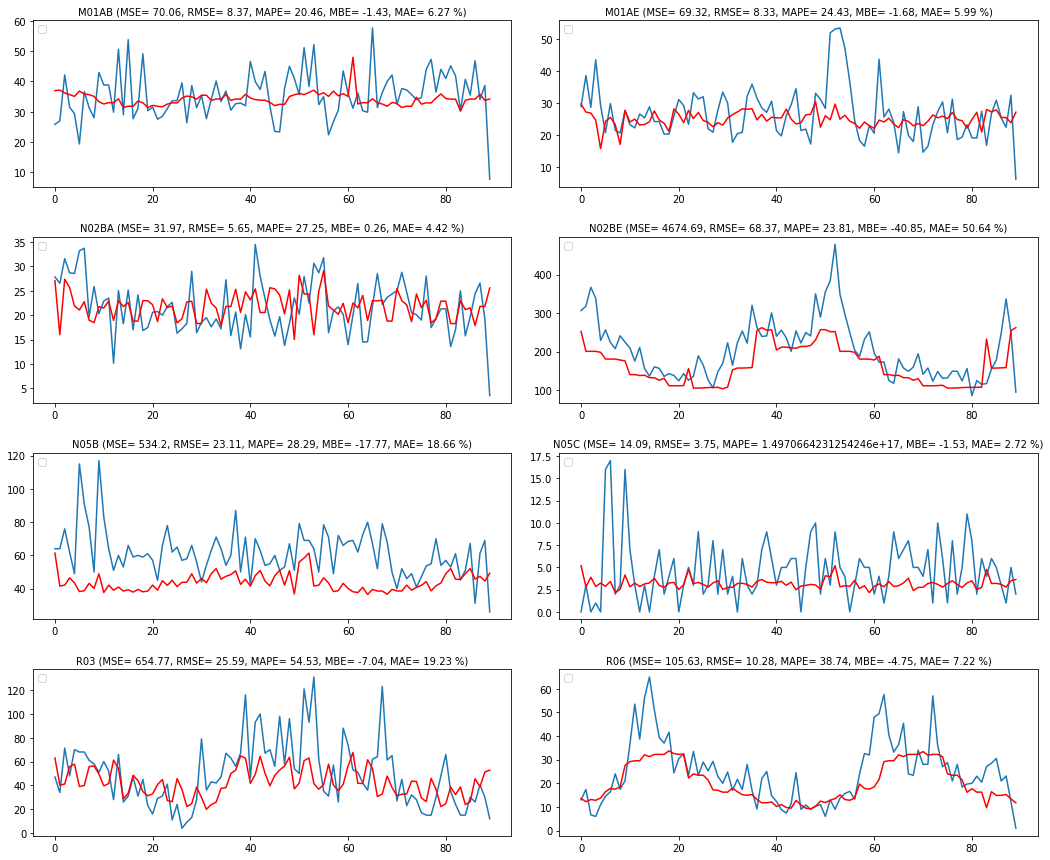

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  dataset = data1.filter([j,"year","month","day"])
  training_data = math.ceil(len(dataset) * 0.7)

  # #create the training data set
  # train_data = sc_data[0:training_data , :]

  #split
  X_train = dataset.iloc[0:training_data,1:]
  y_train = dataset.iloc[0:training_data,0]
  X_test = dataset.iloc[training_data:,1:]
  y_test = dataset.iloc[training_data:,0]
  
  reg = XGBRegressor(n_estimators=1000)
  reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)

  #get the models predicted price values
  predictions = reg.predict(X_test)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(y_test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(y_test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions-y_test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(y_test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(y_test.values)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

# **Autoregression**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(302, 8)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

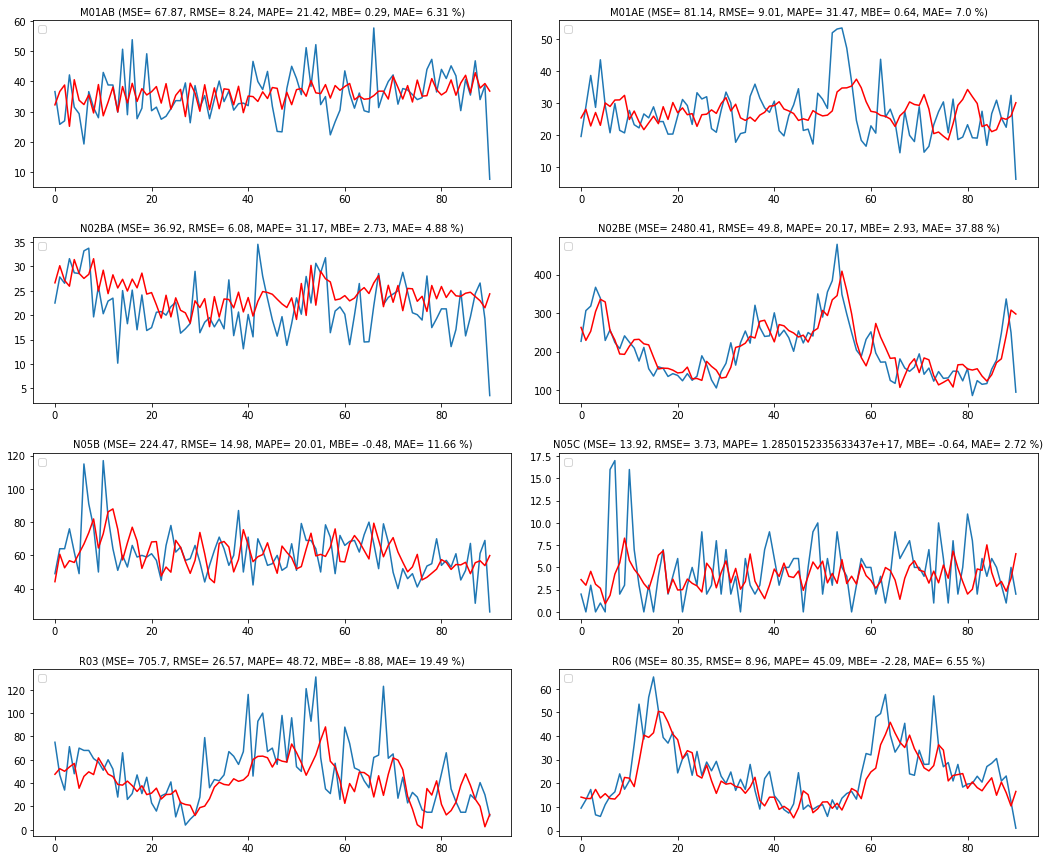

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  train, test = data2[0:int(len(data2)*0.7)], data2[int(len(data2)*0.7):]
  train = train[j].values
  test = test[j].values
  
  # train autoregression
  window = 29
  model = AutoReg(train, lags=29)
  model_fit = model.fit()
  coef = model_fit.params
  # walk forward over time steps in test
  history = train[len(train)-window:]
  history = [history[i] for i in range(len(history))]
  predictions = list()
  for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window , length)]
    yhat = coef[0]
    for d in range(window):
      yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
 
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions - test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(test)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

# **LSTM**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(302, 8)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

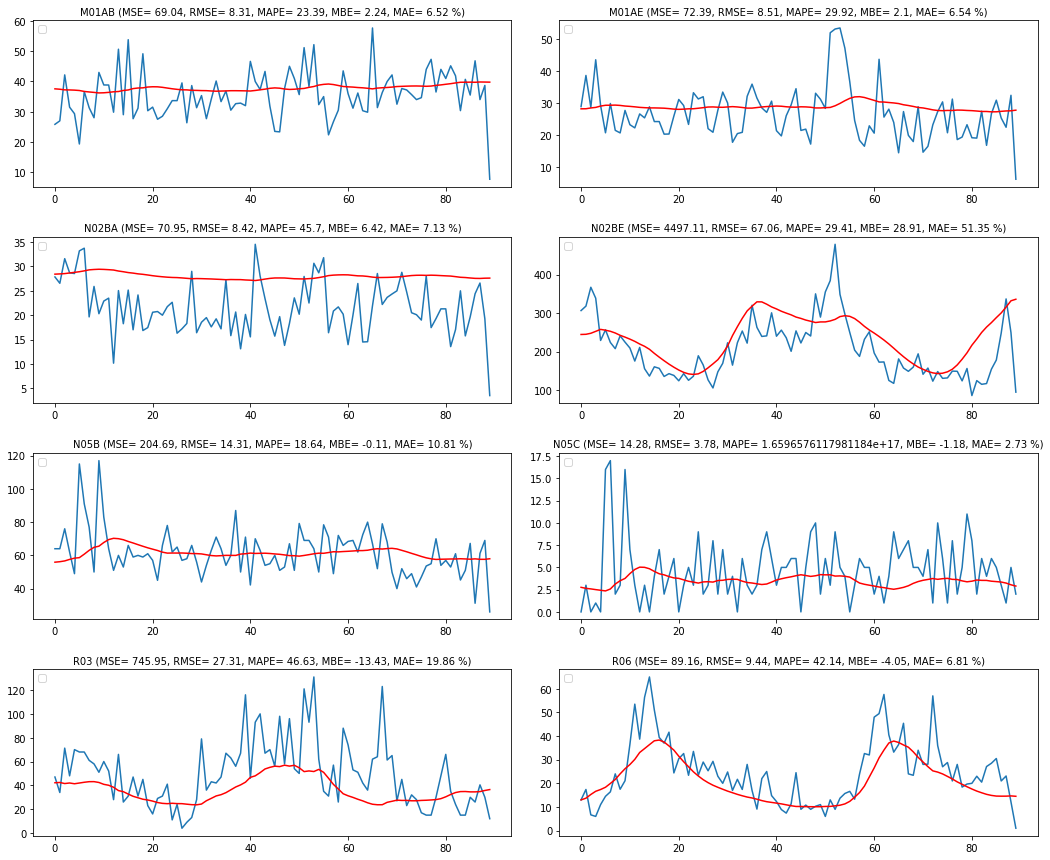

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")
n_steps = 50

for j in features:
  data3 = data2.filter([j])
  dataset = data3.values
  training_data = math.ceil(len(dataset) * 0.7)

  #Normalize the data
  sc = MinMaxScaler(feature_range=(0,1))
  sc_data = sc.fit_transform(dataset)

  #create the training data set
  train_data = sc_data[0:training_data , :]

  #split
  x_train = []
  y_train = []
  for i in range(n_steps, len(train_data)):
    x_train.append(train_data[i-n_steps:i ,0])
    y_train.append(train_data[i ,0])

  #convert the x_train and y_train
  x_train,y_train = np.array(x_train) , np.array(y_train)
  x_train=np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
  
  #create the testing dataset
  test_data = sc_data[training_data - n_steps: ,:]
  x_test = []
  y_test = dataset[training_data:, :]
  for i in range(n_steps , len(test_data)):
    x_test.append(test_data[i-n_steps:i,0])

  #convert the data to a numpy array
  x_test = np.array(x_test)
  x_test = np.reshape(x_test , (x_test.shape[0], x_test.shape[1], 1))

  #build the LSTM model
  model = Sequential()
  model.add(LSTM(100 ,activation='relu' ,return_sequences=True , input_shape=(x_train.shape[1],1)))
  model.add(Dropout(0.2))
  model.add(LSTM(100 ,activation='relu' , return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(1))

  #compile the model
  model.compile(optimizer="adam",loss = "mean_squared_error")

  #Train the model
  history = model.fit(x_train , y_train, epochs=100, verbose=0, validation_split=0.3)

  #get the models predicted price values
  predictions = model.predict(x_test)
  predictions = sc.inverse_transform(predictions)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(y_test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(y_test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions-y_test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(y_test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(y_test)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

# **CNN_LSTM**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(302, 8)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

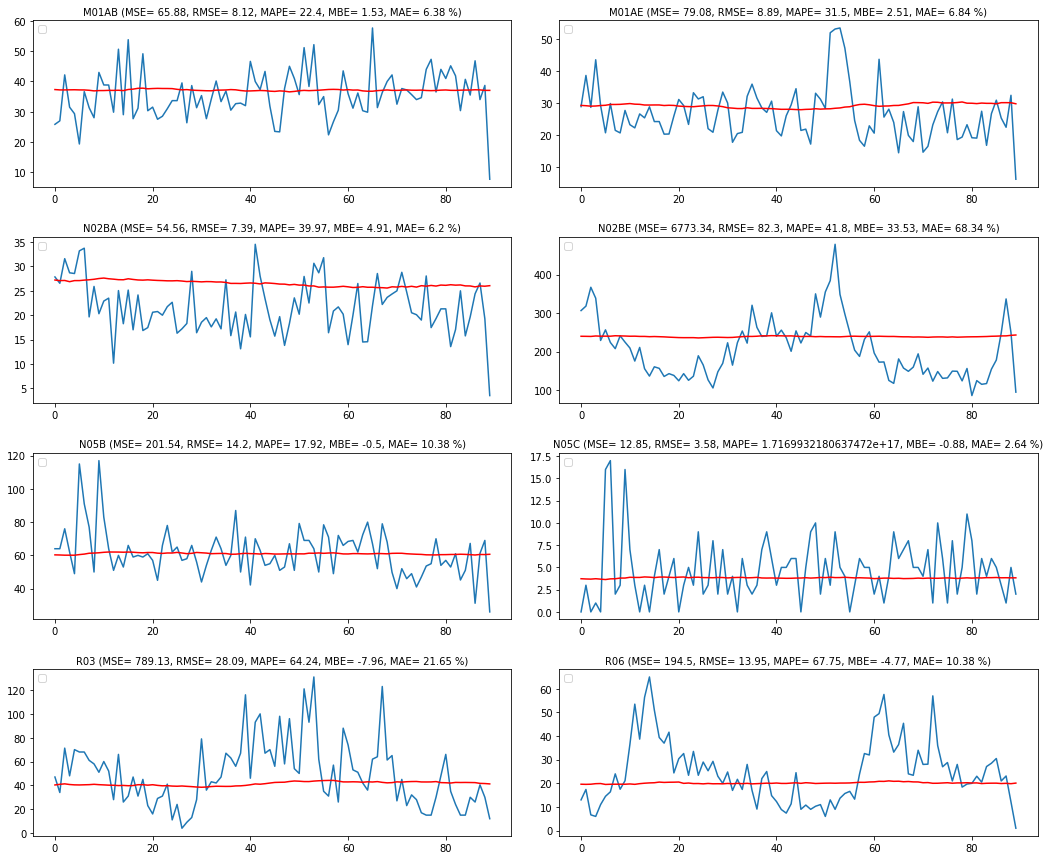

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")
n_steps = 50

for j in features:
  data3 = data2.filter([j])
  dataset = data3.values
  training_data = math.ceil(len(dataset) * 0.7)

  #Normalize the data
  sc = MinMaxScaler(feature_range=(0,1))
  sc_data = sc.fit_transform(dataset)

  #create the training data set
  train_data = sc_data[0:training_data , :]
  
  #split
  x_train = []
  y_train = []
  for i in range(n_steps, len(train_data)):
    x_train.append(train_data[i-n_steps:i ,0])
    y_train.append(train_data[i ,0])

  #convert the x_train and y_train
  x_train,y_train = np.array(x_train) , np.array(y_train)
  x_train=np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
  
  #create the testing dataset
  test_data = sc_data[training_data - n_steps: ,:]
  x_test = []
  y_test = dataset[training_data:, :]
  for i in range(n_steps , len(test_data)):
    x_test.append(test_data[i-n_steps:i,0])
    #y_test.append(test_data[i ,0])

  #convert the data to a numpy array
  x_test = np.array(x_test)
  x_test = np.reshape(x_test , (x_test.shape[0], x_test.shape[1], 1))

  #build the LSTM model
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(RepeatVector(1))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))


  #compile the model
  model.compile(optimizer="adam",loss = "mean_squared_error")

  #Train the model
  history = model.fit(x_train , y_train, epochs=100, verbose=0, validation_split=0.3)

  #get the models predicted price values
  #x_test = x_test.reshape((1, len(x_test), 1))
  predictions = model.predict(x_test)
  predictions = predictions.reshape((len(predictions), 1))
  predictions = sc.inverse_transform(predictions)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(y_test, predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(y_test, predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(predictions-y_test),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(y_test, predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(y_test)
  ax[rowindex,colindex].plot(predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

# **ARIMA**

In [ ]:
data2 = data1.set_index("datum")
data2.shape

(302, 8)

In [ ]:
features = list(data2.columns)
del features[8:]

In [ ]:
#import the libraries
import math
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
mse = []
rmse = []
mape = []
mbe = []
mae = []

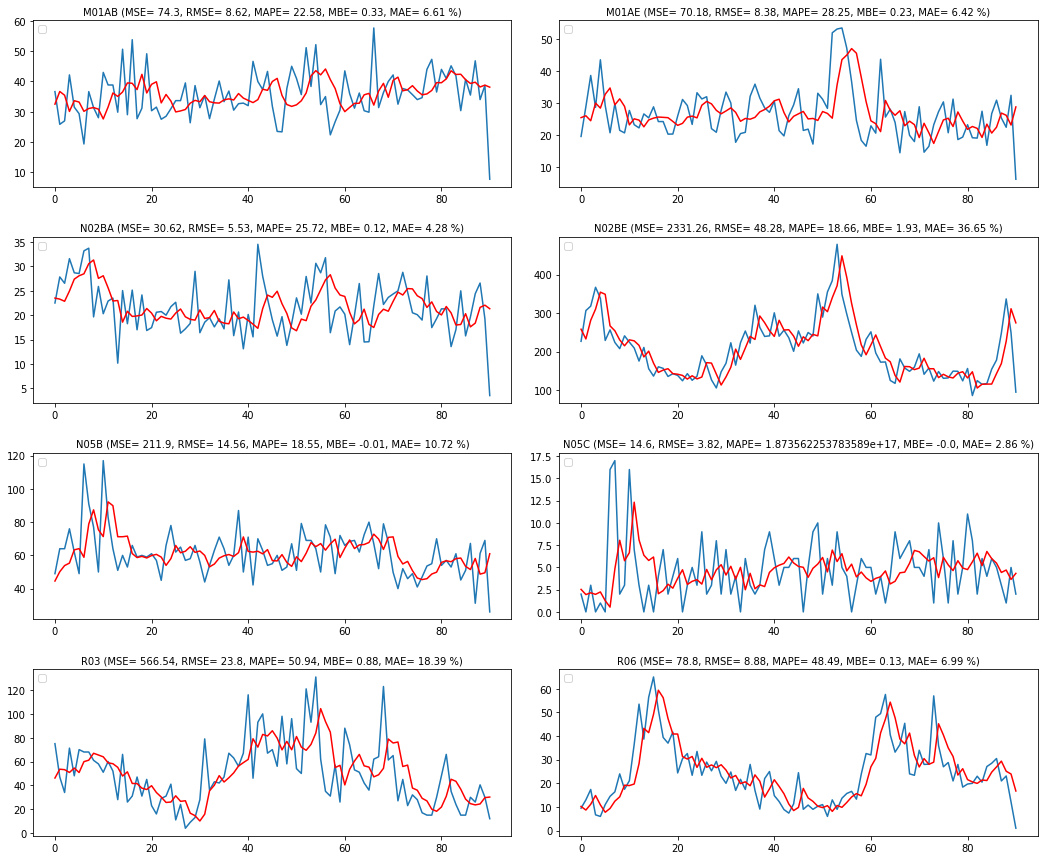

In [ ]:
subplotindex=0
fig, ax = plt.subplots(4, 2, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
warnings.filterwarnings("ignore")

for j in features:
  
  train_data, test_data = data2[0:int(len(data2)*0.7)], data2[int(len(data2)*0.7):]
  training_data = train_data[j].values
  test_data = test_data[j].values
  history = [x for x in training_data]
  model_predictions = []
  N_test_observations = len(test_data)
  for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
  MSE_error = mean_squared_error(test_data, model_predictions)
  
  # Validation
  # Mean Squarred Error (MSE) 
  MSE = np.round(mean_squared_error(test_data, model_predictions),2)
  mse.append(MSE)
  # Root Mean Squarred Error (RMSE) 
  RMSE = np.round(np.sqrt(MSE),2)
  rmse.append(RMSE)
  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.round(mean_absolute_percentage_error(test_data, model_predictions)*100,2)
  mape.append(MAPE)
  # Mean Bias Error (MBE)
  MBE = np.round(np.mean(model_predictions - test_data),2)
  mbe.append(MBE)
  # Mean Absolute Error (MAE)
  MAE = np.round(mean_absolute_error(test_data, model_predictions),2)
  mae.append(MAE)

  #plot the data
  rowindex = math.floor(subplotindex/2)
  colindex = subplotindex-(rowindex*2)
  ax[rowindex,colindex].set_title("{0} (MSE= {1}, RMSE= {2}, MAPE= {3}, MBE= {4}, MAE= {5} %)".format(j ,MSE ,RMSE ,MAPE, MBE, MAE), fontsize = 10)
  ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
  ax[rowindex,colindex].plot(test_data)
  ax[rowindex,colindex].plot(model_predictions, color='red')
  subplotindex=subplotindex+1
plt.show()

In [ ]:
mse

[74.3, 70.18, 30.62, 2331.26, 211.9, 14.6, 566.54, 78.8]

In [ ]:
mape

[22.58, 28.25, 25.72, 18.66, 18.55, 1.873562253783589e+17, 50.94, 48.49]

In [ ]:
rmse

[8.62, 8.38, 5.53, 48.28, 14.56, 3.82, 23.8, 8.88]

In [ ]:
mae

[6.61, 6.42, 4.28, 36.65, 10.72, 2.86, 18.39, 6.99]

In [ ]:
mbe

[0.33, 0.23, 0.12, 1.93, -0.01, -0.0, 0.88, 0.13]